In [94]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from sklearn.metrics import make_scorer, confusion_matrix
import xgboost as xgb

In [2]:
data_path = os.path.join(os.getcwd(), 'ynap_data')
print(data_path)

/nfs/science/shared/ipythonNotebooks/leom/Kaggle/Ynap-master/ynap_data


In [3]:
# os.listdir(data_path)

In [4]:
df_tot = pd.read_csv(os.path.join(data_path, 'df_tot_log.csv'))
df_tot['var3'] = df_tot['var3'].astype('category')
df_tot['var5'] = df_tot['var5'].astype('category')
df_tot['var6'] = df_tot['var6'].astype('category')

In [5]:
df_tot[df_tot['lapsed_next_period'] == 1].shape

(821, 23)

In [7]:
# make dummies out of categorical variables
dummy_idx = np.where(df_tot.dtypes == 'category')[0]
df_dummies = pd.get_dummies(df_tot.iloc[:, dummy_idx])
df = pd.concat([df_tot.drop(df_tot.iloc[:, dummy_idx].columns.values, axis=1), df_dummies], axis=1)

In [9]:
def column_finder(df, col, method=2):
    if method == 1:
        # method 1:
        cols_as_string = ' '.join(df.columns.values)
        cols_found = list(re.findall(col + '.*?\ ', cols_as_string))
        cols_found = [x.strip(' ') for x in cols_found]
    elif method == 2:
        # method 2:
        cols_found = []
        for col_elem in df.columns.values:
            if col in col_elem:
                cols_found.append(col_elem)
    else:
        raise ValueError
            
    return cols_found


def column_remover(df, col_list, noprint=False):    
    if type(col_list) != list:
        cl = []
        cl.append(col_list)
        col_list =cl
    
    col_to_remove = []
    for col in col_list:
        #print(col)
        col_to_remove.extend(column_finder(df, col, method=2))
    
    df.drop(col_to_remove, axis=1, inplace=True)
    if not noprint:
        print(col_to_remove)

In [12]:
# column_remover(df_tot, ['product_id', 'designer_id', '_1989' #, '_199001', '_199002'
#                        ], noprint=True)

columns_to_remove = ['product_id', 'designer_id', 'gross_spend', 'item_bought', 'item_returned',
                                'ns_per_order', 'ir_per_order', 'gs_per_item']

# columns_to_remove = ['product_id', 'designer_id']

column_remover(df, columns_to_remove)
# print(df_tot.columns.values)

['product_id', 'designer_id', 'gross_spend', 'item_bought', 'item_returned', 'ns_per_order', 'ir_per_order', 'gs_per_item']


In [13]:
df.columns.values

array(['customer_id', 'var4', 'lapsed_next_period', 'order_id',
       'product_type_id', 'net_spend', 'quote_spend_returned',
       'quote_var1', 'quote_var2', 'gs_per_order', 'ib_per_order',
       'ns_per_ib', 'var3_0.0', 'var3_1.0', 'var3_2.0', 'var3_3.0',
       'var5_0.0', 'var5_1.0', 'var6_0.0', 'var6_1.0'], dtype=object)

In [14]:
#df_tot.drop('customer_id', axis=1).corr().loc['lapsed_next_period'] # response not correlated with anything...

corr1 = df.drop('customer_id', axis=1).corr()
corr1[corr1.loc['lapsed_next_period'].apply(abs) > 0.15]['lapsed_next_period']
# corr1.loc['lapsed_next_period']

lapsed_next_period    1.000000
order_id             -0.228204
product_type_id      -0.180241
net_spend            -0.191040
Name: lapsed_next_period, dtype: float64

In [ ]:
# corr1

### Data transformation

In [ ]:
def data_transformer(df, unchangeable_variables, method='std'):
    if method == 'std':
        scaler = StandardScaler().fit_transform(df.values)
    elif method == 'minmax':
        scaler = MinMaxScaler().fit_transform(df.values)
    elif method == 'normal':
        scaler = Normalizer().fit_transform(df.values)
    else:
        print('Method not recognized')
        
    df_transformed = pd.DataFrame(scaler, index=df.index, columns=df.columns)
    if len(unchangeable_variables) > 0:
        df_transformed[unchangeable_variables] = df[unchangeable_variables]
    
    return df_transformed

In [ ]:
df_minmax = data_transformer(df_tot, ['customer_id','lapsed_next_period'], 'minmax')
# df_minmax.drop('customer_id', axis=1).corr().loc['lapsed_next_period']

In [ ]:
df_norm = data_transformer(df_tot, ['customer_id','lapsed_next_period'], 'normal')
# df_norm.drop('customer_id', axis=1).corr().loc['lapsed_next_period']

In [ ]:
df_std = data_transformer(df_tot, ['customer_id','lapsed_next_period'], 'std')
# df_std.drop('customer_id', axis=1).corr().loc['lapsed_next_period']

Transformations don't seem to work. One reason could the high sproportion between 0s and 1s in the response variable.
Let's try a balance method.

## Balance
Let's use the standard transformed data

In [15]:
df_for_model = df

In [16]:
X = df_for_model.drop(['customer_id', 'lapsed_next_period'], axis=1)
y = df_for_model[['customer_id', 'lapsed_next_period']]

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

(15695, 18)
(15695, 2)


In [17]:
X_train_1 = X_train.loc[y_train[y_train['lapsed_next_period'] == 1].index]
X_train_0 = X_train.loc[y_train[y_train['lapsed_next_period'] == 0].index]

print(X_train_1.shape)
print(X_train_0.shape)
print(X_train_1.shape[0]/X_train.shape[0])

(657, 18)
(11899, 18)
0.05232558139534884


In [18]:
y_test[y_test['lapsed_next_period'] == 1].shape[0] / y_test.shape[0]

0.052245938196877985

In [19]:
# try different balance ratios with a couple of easy models

def balance_tester(Xtr0, Xtr1, ytr, Xte, yte, zero_quotas = [0.5, 0.66, 0.75], seeds = [21, 2121, 1212], 
                   method='log', method_params=None):
    
    if (method == 'rf') & (method_params == None):
        # Random Forest parameters
        rf_params_bal = {'n_jobs': -1, 'n_estimators': 500, 'warm_start': True, 
                         'max_depth': 4, 'min_samples_leaf': 2, 'max_features' : 'sqrt',
                         'verbose': 0}
    
    results = pd.DataFrame(columns=['quota', 'accuracy', 'pred_perc', 'recall'])
    
    for quota in zero_quotas:
        accuracy = []
        pred_perc = []
        recall = []
        
        n_sample = int(Xtr1.shape[0] * quota / (1 - quota) // 1)
        
        for seed in seeds:
            Xtr0_ = Xtr0.sample(n=n_sample, random_state=seed)
            Xtr_ = Xtr0_.append(Xtr1)
            ytr_ = ytr.loc[Xtr_.index]
            
            if method == 'log':
                clf = LogisticRegression(max_iter=100, solver='liblinear')
            elif method == 'rf':
                clf = RandomForestClassifier(**rf_params_bal)
            else:
                return 'Method not recognized'
            
            clf.fit(Xtr_, ytr_)
            clf_pred = clf.predict(Xte)
            cf = confusion_matrix(yte, clf_pred)
            
            pred_perc.append(clf_pred.sum()/len(clf_pred))
            accuracy.append(accuracy_score(yte, clf_pred))
            recall.append(cf[1, 1] / cf[1, :].sum())
            
            
        # print(np.array(accuracy).mean())
        acc_mean = np.array(accuracy).mean()
        pp_mean = np.array(pred_perc).mean()
        rec_mean = np.array(recall).mean()
        
        results = results.append(pd.Series({'quota': quota, 'accuracy': acc_mean,
                                            'pred_perc': pp_mean, 'recall': rec_mean}),
                                 ignore_index=True)
    
    return results
            
quotas = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.825, 0.85, 0.9]
# quotas = [0.8, 0.805, 0.81, 0.815, 0.82, 0.825, 0.83, 0.835, 0.84, 0.845, 0.85]
balance_res_rf = balance_tester(X_train_0, X_train_1, y_train['lapsed_next_period'], X_test, 
                                y_test['lapsed_next_period'], quotas, method='rf')

balance_res_log = balance_tester(X_train_0, X_train_1, y_train['lapsed_next_period'], X_test, 
                                y_test['lapsed_next_period'], quotas, method='log')

In [20]:
balance_res_log['acc_recall'] = 0.4 * balance_res_log['accuracy'] + 0.6 * balance_res_log['recall']
balance_res_log

,quota,accuracy,pred_perc,recall,acc_recall
0,0.500,0.724116,0.301795,0.747967,0.738427
1,0.550,0.762982,0.254646,0.668699,0.706412
2,0.600,0.800680,0.208453,0.587398,0.672711
3,0.650,0.831687,0.167675,0.493902,0.629016
4,0.700,0.862270,0.130721,0.432927,0.604664
5,0.750,0.892322,0.090050,0.331301,0.555709
6,0.800,0.912286,0.057131,0.207317,0.489305
7,0.825,0.920569,0.043751,0.158537,0.463350
8,0.850,0.930126,0.030583,0.123984,0.446441
9,0.900,0.944887,0.004991,0.020325,0.390150


In [21]:
balance_res_rf['acc_recall'] = 0.4 * balance_res_rf['accuracy'] + 0.6 * balance_res_rf['recall']
balance_res_rf

,quota,accuracy,pred_perc,recall,acc_recall
0,0.500,0.737708,0.281406,0.682927,0.704839
1,0.550,0.775619,0.236275,0.613821,0.678540
2,0.600,0.803865,0.199958,0.536585,0.643497
3,0.650,0.832537,0.165764,0.483740,0.623259
4,0.700,0.865244,0.124774,0.404472,0.588780
5,0.750,0.895827,0.085059,0.317073,0.548575
6,0.800,0.931082,0.033025,0.156504,0.466335
7,0.825,0.940427,0.017734,0.099593,0.435927
8,0.850,0.946267,0.005522,0.038618,0.401678
9,0.900,0.947754,0.000000,0.000000,0.379102


## Models

My objective is to get the highest recall possibile. The overall accuracy doesn't fit for this problem, because classifying the right 1s has more importance than classifying everyone correctly, whether they are 0s or 1s.
The recall measure is perfect for this problem. I want to have the highest percentage possible on classifying the customers I know are true 1s (in other words, I want to minimize the outcome set to 0 to those I know are 1), while I consider less important to have an error on those I classify 1 when they are actually 0.

A basic proportion of 50% for not lapsed values seems to lead to good results. Let's use that for the GridSearch step.

In [22]:
quota = 0.5
n_sample = int(X_train_1.shape[0] * quota / (1 - quota) // 1)
X_train_0_ = X_train_0.sample(n=n_sample, random_state=101)

In [23]:
X_train_ = X_train_0_.append(X_train_1)
print(X_train_.shape)

y_train_ = y_train.loc[X_train_.index]
print(y_train_.shape)

(1314, 18)
(1314, 2)


In [24]:
y_test[y_test['lapsed_next_period'] == 1].shape

(164, 2)

In [25]:
df_ = y_train_.join(X_train_)
y_corr = df_.drop('customer_id', axis=1).corr().loc['lapsed_next_period']

In [26]:
# model_cols = list(y_corr[y_corr.apply(lambda x: abs(x) > 0.15)].index.values)
model_cols = list(X_train_.columns.values)
# model_cols.remove('lapsed_next_period')

In [27]:
model_cols

['var4',
 'order_id',
 'product_type_id',
 'net_spend',
 'quote_spend_returned',
 'quote_var1',
 'quote_var2',
 'gs_per_order',
 'ib_per_order',
 'ns_per_ib',
 'var3_0.0',
 'var3_1.0',
 'var3_2.0',
 'var3_3.0',
 'var5_0.0',
 'var5_1.0',
 'var6_0.0',
 'var6_1.0']

In [28]:
# Logistic Regression for feature selection
log_test = LogisticRegression()
log_test = log_test.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
score_log = log_test.score(X_train_[model_cols], y_train_['lapsed_next_period'])
print(score_log)

0.737442922374


In [29]:
pd.DataFrame(list(zip(X_train_[model_cols].columns, np.transpose(log_test.coef_))))

,0,1
0,var4,[-0.0566413229487]
1,order_id,[-0.809969788516]
2,product_type_id,[-0.022418823623]
3,net_spend,[-0.0763324628972]
4,quote_spend_returned,[-1.37913763766]
5,quote_var1,[0.0611310977907]
6,quote_var2,[-0.0517798271361]
7,gs_per_order,[0.651419067133]
8,ib_per_order,[-0.406952424115]
9,ns_per_ib,[-0.544371558201]


*product_type_id* seems not really effective as a predictor.

In [32]:
model_cols.remove('product_type_id')

ValueError: list.remove(x): x not in list

In [33]:
model_cols

['var4',
 'order_id',
 'net_spend',
 'quote_spend_returned',
 'quote_var1',
 'quote_var2',
 'gs_per_order',
 'ib_per_order',
 'ns_per_ib',
 'var3_0.0',
 'var3_1.0',
 'var3_2.0',
 'var3_3.0',
 'var5_0.0',
 'var5_1.0',
 'var6_0.0',
 'var6_1.0']

In [34]:
# REPEAT Logistic Regression for feature selection
log_test = LogisticRegression()
log_test = log_test.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
score_log = log_test.score(X_train_[model_cols], y_train_['lapsed_next_period'])
print(score_log)

0.730593607306


In [35]:
pd.DataFrame(list(zip(X_train_[model_cols].columns, np.transpose(log_test.coef_))))

,0,1
0,var4,[-0.0592772334508]
1,order_id,[-0.918768681656]
2,net_spend,[-0.138552454757]
3,quote_spend_returned,[-1.47756606124]
4,quote_var1,[0.0605165529204]
5,quote_var2,[-0.0595461000229]
6,gs_per_order,[0.649979268231]
7,ib_per_order,[-0.507817358798]
8,ns_per_ib,[-0.411519872854]
9,var3_0.0,[0.118876260841]


In [36]:
# Random Forest example
rf_params = {
    'n_jobs': -1,
    'n_estimators': 200,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 4,
    'min_samples_leaf': 4,
    'max_features' : 'sqrt',
    'verbose': 0
}

rf = RandomForestClassifier(**rf_params)
rf.fit(X_train_[model_cols], y_train_['lapsed_next_period'])

rf_pred = rf.predict(X_test[model_cols])

print(rf_pred.sum()/len(rf_pred))

print(accuracy_score(y_test['lapsed_next_period'], rf_pred))

0.300095571838
0.721567378146


In [37]:
cf = confusion_matrix(y_test['lapsed_next_period'], rf_pred)
cf[1,1]/cf[1,:].sum()

0.70731707317073167

In [38]:
def right_classification(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    return cf[1, 1] / cf[1, :].sum()

In [39]:
# Setting multiple hyperparameters for every classifier we are going to implement

# Random Forest
rf_params_gs = {
    'n_jobs': [-1],
    'n_estimators': [150, 175, 200, 225 , 250, 275], #300, 350, 400, 500],
    'warm_start': [True], 
     #'max_features': 0.2,
    'max_depth': [2, 3, 4], # 5, 6],
    'min_samples_leaf': [4, 5, 6], #[2, 3]
    'max_features' : ['sqrt'],
    'verbose': [0]
}

# Extra Trees
et_params_gs = {
    'n_jobs': [-1],
    'n_estimators': [500, 550, 600],
    'max_depth': [6, 7, 8],
    'min_samples_leaf': [2, 3, 4],
    'verbose': [0]
}

# AdaBoost parameters
ada_params_gs = {
    'n_estimators': [150, 200, 250, 300],
    'learning_rate': [1e-3, 0.01, 0.05, 0.1]
}

# Gradient Boosting parameters
gb_params_gs = {
    'n_estimators': [150, 200, 250, 300],
    'max_depth': [2, 3, 4, 5],
    'min_samples_leaf': [4, 5, 6],
    'verbose': [0]
}

# SVC parameters
svc_params_gs = {
    'kernel': ['linear', 'rbf'],
    'C': [1e-4, 1e-3, 0.01, 0.05]
}

# Logistic regression parameters
log_params_gs = {
    'solver': ['liblinear'],
    'max_iter': [100, 200, 300],
    'verbose': [0]
}

# XGBoosting parameters
xgb_params_gs = {
    'objective':['binary:logistic'],
    'learning_rate': [1e-4, 1e-3, 5e-3, 0.01], #so called `eta` value
    'max_depth': [4, 5, 6],
    'min_child_weight': [11],
    'silent': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.7],
    'n_estimators': [200, 400, 600, 800, 1000], #number of trees, change it to 1000 for better results
    'missing':[-999]
}

In [40]:
scoring = {'right_class': make_scorer(right_classification)}

In [41]:
# Istantiate the classifiers
rf = GridSearchCV(RandomForestClassifier(), rf_params_gs, cv=5, scoring=scoring, refit='right_class')
et = GridSearchCV(ExtraTreesClassifier(), et_params_gs, cv=5, scoring=scoring, refit='right_class')
ada = GridSearchCV(AdaBoostClassifier(), ada_params_gs, cv=5, scoring=scoring, refit='right_class')
gb = GridSearchCV(GradientBoostingClassifier(), gb_params_gs, cv=5, scoring=scoring, refit='right_class')
svc = GridSearchCV(SVC(), svc_params_gs, cv=5, scoring=scoring, refit='right_class')
log = GridSearchCV(LogisticRegression(), log_params_gs, cv=5, scoring=scoring, refit='right_class')
xgbm = GridSearchCV(xgb.XGBClassifier(), xgb_params_gs, cv=5, scoring=scoring, refit='right_class')

In [42]:
def classifier_runner(clf, Xtr, ytr, Xte, yte):
    print('-'*40)
    print(clf.estimator)
    print('-'*40)
    clf.fit(Xtr, ytr)
    clf.best_params_
    print(clf.best_params_)
    
    print()
    
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r" % (mean, std*2, params))
        
    print()
    y_true, y_pred = yte, clf.predict(Xte)
    print(classification_report(y_true, y_pred))
    print(accuracy_score(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    print(right_classification(y_true, y_pred))
    
    return clf, y_pred

In [43]:
rf_clf, rf_ypred = classifier_runner(rf, X_train_[model_cols], y_train_['lapsed_next_period'],
                                      X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
----------------------------------------
{'max_depth': 4, 'n_jobs': -1, 'warm_start': True, 'verbose': 0, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'n_estimators': 200}


             precision    recall  f1-score   support

          0       0.98      0.73      0.83      2975
          1       0.12      0.70      0.21       164

avg / total       0.93      0.73      0.80      3139

0.72602739726
[[2165  810]
 [  50  114]]
0.69512195122


In [44]:
et_clf, et_ypred = classifier_runner(et, X_train_[model_cols], y_train_['lapsed_next_period'],
                                      X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
----------------------------------------
{'min_samples_leaf': 4, 'max_depth': 7, 'verbose': 0, 'n_jobs': -1, 'n_estimators': 500}


             precision    recall  f1-score   support

          0       0.98      0.72      0.83      2975
          1       0.12      0.71      0.21       164

avg / total       0.93      0.72      0.80      3139

0.718381650207
[[2139  836]
 [  48  116]]
0.707317073171


In [45]:
ada_clf, ada_ypred = classifier_runner(ada, X_train_[model_cols], y_train_['lapsed_next_period'],
                                        X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
----------------------------------------
{'learning_rate': 0.05, 'n_estimators': 200}


             precision    recall  f1-score   support

          0       0.98      0.71      0.82      2975
          1       0.12      0.73      0.21       164

avg / total       0.93      0.71      0.79      3139

0.712965912711
[[2119  856]
 [  45  119]]
0.725609756098


In [46]:
gb_clf, gb_ypred = classifier_runner(gb, X_train_, y_train_['lapsed_next_period'], X_test, y_test['lapsed_next_period'])

----------------------------------------
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
----------------------------------------
{'min_samples_leaf': 5, 'max_depth': 2, 'verbose': 0, 'n_estimators': 200}


             precision    recall  f1-score   support

          0       0.98      0.70      0.81      2975
          1       0.12      0.74      0.20       164

avg / total       0.93      0.70      0.78      3139

0.698630136986
[[2072  903]
 [  43  121]]
0.737804878049


In [47]:
svc_clf, svc_ypred = classifier_runner(svc, X_train_, y_train_['lapsed_next_period'], X_test, y_test['lapsed_next_period'])

----------------------------------------
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
----------------------------------------
{'C': 0.0001, 'kernel': 'linear'}


             precision    recall  f1-score   support

          0       0.98      0.62      0.76      2975
          1       0.09      0.72      0.17       164

avg / total       0.93      0.62      0.73      3139

0.622809812042
[[1837 1138]
 [  46  118]]
0.719512195122


In [48]:
log_clf, log_ypred =classifier_runner(log, X_train_[model_cols], y_train_['lapsed_next_period'], X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
----------------------------------------
{'verbose': 0, 'max_iter': 100, 'solver': 'liblinear'}


             precision    recall  f1-score   support

          0       0.98      0.72      0.83      2975
          1       0.13      0.73      0.21       164

avg / total       0.93      0.72      0.80      3139

0.722204523734
[[2148  827]
 [  45  119]]
0.725609756098


In [49]:
xgbm_clf, xgbm_ypred = classifier_runner(xgbm, X_train_[model_cols], y_train_['lapsed_next_period'], X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
----------------------------------------
{'objective': 'binary:logistic', 'max_depth': 5, 'learning_rate': 0.01, 'missing': -999, 'silent': 1, 'subsample': 0.8, 'colsample_bytree': 0.7, 'min_child_weight': 11, 'n_estimators': 400}


             precision    recall  f1-score   support

          0       0.98      0.71      0.82      2975
          1       0.12      0.71      0.20       164

avg / total       0.93      0.71      0.79      3139

0.706594456833
[[2102  873]
 [  48  116]]
0.707317073171


### Feature importances

In [66]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
rf_best = SklearnHelper(clf=RandomForestClassifier, params=rf_clf.best_params_)
et_best = SklearnHelper(clf=ExtraTreesClassifier, params=et_clf.best_params_)
ada_best = SklearnHelper(clf=AdaBoostClassifier, params=ada_clf.best_params_)
gb_best = SklearnHelper(clf=GradientBoostingClassifier, params=gb_clf.best_params_)
svc_best = SklearnHelper(clf=SVC, params=svc_clf.best_params_)
log_best = SklearnHelper(clf=LogisticRegression, params=log_clf.best_params_)
xgbm_best = SklearnHelper(clf=xgb.XGBClassifier, params=xgbm_clf.best_params_)

In [67]:
rf_best = rf_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
et_best = et_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
ada_best = ada_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
gb_best = gb_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
svc_best = svc_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
log_best = log_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
xgbm_best = xgbm_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])

In [85]:
rf_best_score = right_classification(y_pred=rf_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
et_best_score = right_classification(y_pred=et_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
ada_best_score = right_classification(y_pred=ada_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
gb_best_score = right_classification(y_pred=gb_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
svc_best_score = right_classification(y_pred=svc_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
log_best_score = right_classification(y_pred=log_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
xgbm_best_score = right_classification(y_pred=xgbm_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])

In [87]:
rf_best_score_test = right_classification(y_pred=rf_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
et_best_score_test = right_classification(y_pred=et_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
ada_best_score_test = right_classification(y_pred=ada_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
gb_best_score_test = right_classification(y_pred=gb_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
svc_best_score_test = right_classification(y_pred=svc_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
log_best_score_test = right_classification(y_pred=log_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
xgbm_best_score_test = right_classification(y_pred=xgbm_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])

In [89]:
models = pd.DataFrame({
    'Model': ['Random Forests', 'Extratrees', 'AdaBoosting', 
              'Gradient Boosting', 'Support Vector Machine', 
              'Logistic Regression','XGBoost'],
    'Score on training': [rf_best_score, et_best_score, ada_best_score, gb_best_score, 
              svc_best_score, log_best_score, xgbm_best_score],
    'Score on test': [rf_best_score_test, et_best_score_test, ada_best_score_test, gb_best_score_test, 
              svc_best_score_test, log_best_score_test, xgbm_best_score_test]})
models.sort_values(by='Score on training', ascending=False)

,Model,Score on test,Score on training
4,Support Vector Machine,0.865854,0.888889
3,Gradient Boosting,0.725610,0.820396
6,XGBoost,0.707317,0.808219
1,Extratrees,0.713415,0.768645
0,Random Forests,0.713415,0.753425
2,AdaBoosting,0.725610,0.742770
5,Logistic Regression,0.725610,0.738204


In [77]:
summary = pd.DataFrame(list(zip(X_train_[model_cols].columns,
    np.transpose(rf_best.feature_importances_),
    np.transpose(et_best.feature_importances_),
    np.transpose(ada_best.feature_importances_),
    np.transpose(gb_best.feature_importances_),
    np.transpose(xgbm_best.feature_importances_),
    )), columns=['Feature','RF','Extra','Ada','GB','XGB'])
  
summary['Median'] = summary.median(1)
summary.sort_values('Median', ascending=False)

,Feature,RF,Extra,Ada,GB,XGB,Median
1,order_id,0.370429,0.365752,0.280,0.132363,0.139013,0.280000
2,net_spend,0.230516,0.191806,0.080,0.136212,0.141846,0.141846
6,gs_per_order,0.062132,0.035686,0.145,0.139623,0.139485,0.139485
3,quote_spend_returned,0.117549,0.084304,0.125,0.112191,0.123200,0.117549
0,var4,0.059745,0.103787,0.165,0.113569,0.082606,0.103787
7,ib_per_order,0.042541,0.021898,0.025,0.113463,0.106915,0.042541
8,ns_per_ib,0.036313,0.020351,0.020,0.116611,0.120132,0.036313
4,quote_var1,0.023801,0.034588,0.100,0.040315,0.020297,0.034588
5,quote_var2,0.027762,0.020499,0.000,0.055828,0.079065,0.027762
13,var5_0.0,0.007923,0.031661,0.030,0.006191,0.018881,0.018881


### Ensembling

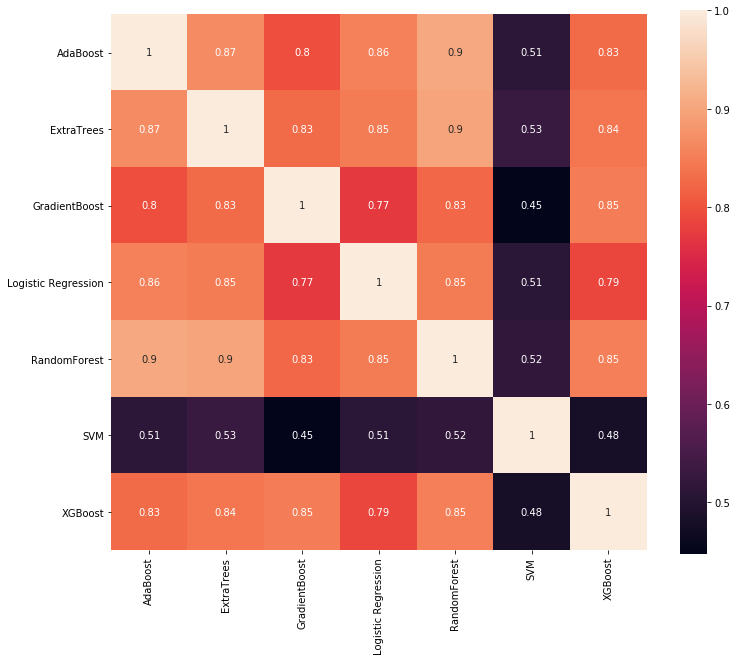

In [93]:
# correlation between model predictions on training data
base_predictions_train = pd.DataFrame( {'RandomForest': rf_best.predict(X_train_[model_cols]),
     'ExtraTrees': et_best.predict(X_train_[model_cols]),
     'AdaBoost': ada_best.predict(X_train_[model_cols]),
     'SVM' : svc_best.predict(X_train_[model_cols]),
     'GradientBoost': gb_best.predict(X_train_[model_cols]),
     'Logistic Regression': log_best.predict(X_train_[model_cols]),
     'XGBoost': xgbm_best.predict(X_train_[model_cols])
    })

plt.figure(figsize=(12,10))
foo = sns.heatmap(base_predictions_train.corr(), vmax=1.0, square=True, annot=True)

In [95]:
# Voting classifier
clf_vote = VotingClassifier(
    estimators=[
        #('tree', clf_tree),
        ('rf', rf_best),
        ('et', et_best),
        ('ada', ada_best),
        ('gb', gb_best),
        ('xgb', xgbm_best),
        ('svm', svc_best),
        ('logistic', log_best)
        ],
    weights=[1,1,1,2,2,3,1],
    voting='hard')
clf_vote.fit(X_train_[model_cols], y_train_['lapsed_next_period'])

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weigh...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard',
         weights=[1, 1, 1, 2, 2, 3, 1])

In [97]:
clf_vote_score_train = right_classification(y_pred=clf_vote.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
clf_vote_score_train

0.78995433789954339

In [98]:
clf_vote_score_test = right_classification(y_pred=clf_vote.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
clf_vote_score_test

0.74390243902439024

In [101]:
print(confusion_matrix(y_pred=clf_vote.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period']))

[[2042  933]
 [  42  122]]


In [102]:
print(confusion_matrix(y_test['lapsed_next_period'], svc_best.predict(X_test[model_cols])))

[[1167 1808]
 [  22  142]]
